In [9]:
import astropy.time
import numpy as np
import pandas as pd
import sp3

from astropy import coordinates as coord

# Define the start and end times
start_time = astropy.time.Time('2020-03-01T00:00:00', scale='utc')
end_time = astropy.time.Time('2020-03-02T00:00:00', scale='utc')

start_time_gps = start_time - 18 * astropy.units.second
end_time_gps = end_time - 18 * astropy.units.second

# Create a range of times every 15 minutes
delta_t = 15 * 60  # 15 minutes in seconds
obstime = astropy.time.Time(np.arange(start_time_gps.jd, end_time_gps.jd, delta_t / 86400.0), format='jd', scale='utc')

# Download and interpolate the SP3 data
itrs_positions = sp3.itrs(
    id = sp3.NoradId(25933),
    obstime=obstime,
    download_directory="sp3_cache",
    window=5,
    degree=10
)

# Convert ITRS to GCRS
gcrs_positions = itrs_positions.transform_to(coord.GCRS(obstime=obstime))

# Create a DataFrame
navstar_46_sp3_ephem = pd.DataFrame({
    "utc": obstime.utc.iso,
    "x": gcrs_positions.cartesian.x.value,
    "y": gcrs_positions.cartesian.y.value,
    "z": gcrs_positions.cartesian.z.value
})

# Add a 'GPST' column to the DataFrame
gps_times = obstime.utc + astropy.time.TimeDelta(18 * astropy.units.second)
navstar_46_sp3_ephem["GPST"] = gps_times.iso


In [10]:
navstar_46_sp3_ephem.head()

,utc,x,y,z,GPST
0,2020-02-29 23:59:42.000,-1.968828e+07,2.439932e+06,1.703324e+07,2020-03-01 00:00:00.000
1,2020-03-01 00:14:42.000,-2.122140e+07,-2.362821e+05,1.530070e+07,2020-03-01 00:15:00.000
2,2020-03-01 00:29:42.000,-2.237258e+07,-2.908261e+06,1.329269e+07,2020-03-01 00:30:00.000
3,2020-03-01 00:44:42.000,-2.312210e+07,-5.528050e+06,1.104598e+07,2020-03-01 00:45:00.000
4,2020-03-01 00:59:42.000,-2.345787e+07,-8.048945e+06,8.601530e+06,2020-03-01 01:00:00.000


In [5]:
#move back to the root directory
import os
os.chdir('..')

In [11]:
!pwd

/Users/charlesc/Documents/GitHub/ERP_tools


In [43]:

import spacetrack.operators as op
from spacetrack import SpaceTrackClient
import getpass
from datetime import datetime, timedelta
startdate = datetime(2020, 2, 3, 00, 00, 00, 00000)
# Extending collection duration to test data availability
duration_days = 50  # days
enddate = startdate + timedelta(days=duration_days)

identity_st = input('Enter SpaceTrack username: ')
password_st = getpass.getpass(prompt=f'Enter SpaceTrack password for account {identity_st}: ')

st = SpaceTrackClient(identity=identity_st, password=password_st)

try:
    rawTles = st.tle(norad_cat_id=25933, epoch=op.inclusive_range(startdate, enddate),
                     orderby='epoch asc', format='tle')
    if rawTles:
        print("rawTles: ", rawTles)
    else:
        print("No TLE data found for the specified range.")
except Exception as e:
    print(f"An error occurred: {e}")

rawTles:  1 25933U 99055A   20034.07742266 -.00000051 +00000-0 +00000-0 0  9990
2 25933 052.2488 035.8448 0156252 113.7358 005.2326 02.00657620148924
1 25933U 99055A   20034.40944681 -.00000049  00000-0  00000+0 0  9998
2 25933  52.2490  35.8305 0156243 113.7388 245.0823  2.00657606148922
1 25933U 99055A   20035.41464311 -.00000046 +00000-0 +00000-0 0  9995
2 25933 052.2495 035.7870 0156222 113.7481 251.2222 02.00657565148953
1 25933U 99055A   20035.63155056 -.00000045 +00000-0 +00000-0 0  9991
2 25933 052.2496 035.7776 0156217 113.7524 047.9111 02.00657557148959
1 25933U 99055A   20036.65331584 -.00000043  00000-0  00000+0 0  9993
2 25933  52.2502  35.7334 0156195 113.7608  66.0212  2.00657514148963
1 25933U 99055A   20037.17090073 -.00000043 +00000-0 +00000-0 0  9997
2 25933 052.2504 035.7110 0156186 113.7660 079.9169 02.00657493148987
1 25933U 99055A   20037.59290304 -.00000043 +00000-0 +00000-0 0  9992
2 25933 052.2507 035.6928 0156178 113.7692 024.7662 02.00657478148992
1 25933U 9

In [44]:
from collections import OrderedDict

# Split the raw string by newlines
tle_lines = rawTles.strip().split('\n')

# Group every two lines to form individual TLEs
tle_list = ['\n'.join(tle_lines[i:i+2]) for i in range(0, len(tle_lines), 2)]

tle_list = list(OrderedDict.fromkeys(tle_list))

print(tle_list)

['1 25933U 99055A   20034.07742266 -.00000051 +00000-0 +00000-0 0  9990\n2 25933 052.2488 035.8448 0156252 113.7358 005.2326 02.00657620148924', '1 25933U 99055A   20034.40944681 -.00000049  00000-0  00000+0 0  9998\n2 25933  52.2490  35.8305 0156243 113.7388 245.0823  2.00657606148922', '1 25933U 99055A   20035.41464311 -.00000046 +00000-0 +00000-0 0  9995\n2 25933 052.2495 035.7870 0156222 113.7481 251.2222 02.00657565148953', '1 25933U 99055A   20035.63155056 -.00000045 +00000-0 +00000-0 0  9991\n2 25933 052.2496 035.7776 0156217 113.7524 047.9111 02.00657557148959', '1 25933U 99055A   20036.65331584 -.00000043  00000-0  00000+0 0  9993\n2 25933  52.2502  35.7334 0156195 113.7608  66.0212  2.00657514148963', '1 25933U 99055A   20037.17090073 -.00000043 +00000-0 +00000-0 0  9997\n2 25933 052.2504 035.7110 0156186 113.7660 079.9169 02.00657493148987', '1 25933U 99055A   20037.59290304 -.00000043 +00000-0 +00000-0 0  9992\n2 25933 052.2507 035.6928 0156178 113.7692 024.7662 02.00657478

In [45]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, datetime_to_absolutedate
from datetime import datetime, timedelta

# orekit.pyhelpers.download_orekit_data_curdir()
vm = orekit.initVM()
setup_orekit_curdir("misc/orekit-data.zip")

from org.orekit.frames import FramesFactory, ITRFVersion
from org.orekit.utils import PVCoordinates
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.utils import PVCoordinates, IERSConventions
from org.orekit.orbits import KeplerianOrbit, CartesianOrbit
from org.orekit.forces import ForceModel, BoxAndSolarArraySpacecraft, Panel
from org.orekit.propagation import SpacecraftState
from org.orekit.utils import Constants

import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone

def TEME_to_EME2000(teme_pos, teme_vel, mjds):
    # Orekit Frames
    frame_TEME = FramesFactory.getTEME()
    frame_EME2000 = FramesFactory.getEME2000()

    # Prepare output arrays
    eme2000_pos = np.empty_like(teme_pos)
    eme2000_vel = np.empty_like(teme_vel)

    # Iterate over each row of position, velocity, and corresponding MJD
    for i in range(len(teme_pos)):
        # Convert MJD to Julian Date and then to UTC datetime
        mjd = mjds.iloc[i]
        jd = mjd + 2400000.5
        base_date = datetime(1858, 11, 17, tzinfo=timezone.utc)
        
        # Convert to datetime
        dt = base_date + timedelta(days=(jd - 2400000.5))
        
        # Convert datetime to AbsoluteDate
        absolute_date = datetime_to_absolutedate(dt)

        # Convert inputs to Orekit's Vector3D and PVCoordinates (and convert from km to m)
        teme_pos_vector = Vector3D(float(teme_pos[i, 0] * 1000), float(teme_pos[i, 1] * 1000), float(teme_pos[i, 2] * 1000))
        teme_vel_vector = Vector3D(float(teme_vel[i, 0] * 1000), float(teme_vel[i, 1] * 1000), float(teme_vel[i, 2] * 1000))
        pv_teme = PVCoordinates(teme_pos_vector, teme_vel_vector)

        # Transform Coordinates from TEME to EME2000
        teme_to_eme2000 = frame_TEME.getTransformTo(frame_EME2000, absolute_date)
        pv_eme2000 = teme_to_eme2000.transformPVCoordinates(pv_teme)

        # Extract position and velocity from transformed coordinates and convert back from m to km
        eme2000_pos[i] = np.array([pv_eme2000.getPosition().getX(), pv_eme2000.getPosition().getY(), pv_eme2000.getPosition().getZ()]) / 1000
        eme2000_vel[i] = np.array([pv_eme2000.getVelocity().getX(), pv_eme2000.getVelocity().getY(), pv_eme2000.getVelocity().getZ()]) / 1000

    return eme2000_pos, eme2000_vel

from datetime import datetime, timedelta, timezone
from sgp4.api import Satrec
from typing import Dict, List, Union, Tuple, Any 

def sgp4_prop_TLE(TLE: str, jd_start: float, jd_end: float, dt: float, alt_series: bool = False) -> List[List[Any]]:
    """
    Given a TLE, a start time, end time, and time step, propagate the TLE and return the time-series of Cartesian coordinates and accompanying time-stamps (MJD).
    
    This is simply a wrapper for the SGP4 routine in the sgp4.api package (Brandon Rhodes).

    Parameters
    ----------
    TLE : str
        TLE to be propagated.
    jd_start : float
        Start time of propagation in Julian Date format.
    jd_end : float
        End time of propagation in Julian Date format.
    dt : float
        Time step of propagation in seconds.
    alt_series : bool, optional
        If True, return the altitude series as well as the position series. Defaults to False.

    Returns
    -------
    list
        List of lists containing the time-series of Cartesian coordinates, and accompanying time-stamps (MJD).
    """
    if jd_start > jd_end:
        print('jd_start must be less than jd_end')
        return

    ephemeris = []
    
    #convert dt from seconds to julian day
    dt_jd = dt/86400

    #split at the new line
    split_tle = TLE.split('\n')
    s = split_tle[0]
    r = split_tle[1]

    fr = 0.0 # precise fraction (SGP4 docs for more info)
    
    #create a satellite object
    satellite = Satrec.twoline2rv(s, r)

    time = jd_start
    # for i in range (jd_start, jd_end, dt):
    while time < jd_end:
        # propagate the satellite to the next time step
        # Position is in idiosyncratic True Equator Mean Equinox coordinate frame used by SGP4
        # Velocity is the rate at which the position is changing, expressed in kilometers per second
        error, position, velocity = satellite.sgp4(time, fr)
        if error != 0:
            print('Satellite position could not be computed for the given date')
            break
        else:
            ephemeris.append([time,position, velocity]) #jd time, pos, vel
        time += dt_jd

    return ephemeris

def TLE_time(TLE: str) -> float:
    """
    Find the time of a TLE in Julian Day format.

    Parameters
    ----------
    TLE : str
        The TLE string.

    Returns
    -------
    float
        Time in Julian Day format.
    """
    # Extract the epoch section of the TLE
    epoch = TLE[18:32]
    # Convert the first two digits of the epoch to the year
    year = 2000 + int(epoch[0:2])
    
    # The rest of the digits are the day of the year and fractional portion of the day
    day = float(epoch[2:])
    # Convert the day of the year to a day, month, year format
    # Calculate the whole day and the fraction of the day separately
    whole_day = int(day)
    day_fraction = day - whole_day
    # Add the whole days to the first day of the year
    date = datetime(year, 1, 1) + timedelta(days=whole_day - 1)
    # Add the day fraction in terms of seconds (day fraction multiplied by the number of seconds in a day)
    date += timedelta(seconds=day_fraction * 86400)
    # Convert the date to a Julian date
    jd = (date - datetime(1858, 11, 17)).total_seconds() / 86400.0 + 2400000.5
    return jd

def combine_TLE2eph(TLE_list: List[str], jd_start: float, jd_stop: float, dt: float=(15 * 60)) -> Tuple[List[Any], List[Any]]:
    """
    Take a list of TLEs and return an ephemeris that updates with each new TLE. Outputs a position and velocity every 15 minutes from the hour.

    Parameters
    ----------
    TLE_list : list
        List of TLEs (use read_TLEs function to generate this).
    jd_start : float
        Start time in JD.
    jd_stop : float
        Stop time in JD.
    dt : float
        Time step in seconds.

    Returns
    -------
    Tuple[List[Any], List[Any]]
        Ephemeris of the satellite in ECI coordinates(time, pos, vel) and orbit ages.
    """
    dt_jd = dt / 86400
    current_jd = jd_start
    n_steps = int((jd_stop - jd_start) / dt_jd)
    ephemeris = []
    orbit_ages = []

    # Keep track of the current TLE index
    current_tle_idx = 0

    while current_jd < jd_stop:
        found_tle = False  # Flag to track if a matching TLE is found

        for i in range(current_tle_idx, len(TLE_list)):
            TLE_jd = TLE_time(TLE_list[i])
            next_TLE_jd = TLE_time(TLE_list[i + 1]) if i < len(TLE_list) - 1 else TLE_time(TLE_list[0])
            print(f"TLE jd: {TLE_jd}, next TLE jd: {next_TLE_jd}, current jd: {current_jd}")
            if TLE_jd < current_jd < next_TLE_jd:
                print(f"Found TLE for current time: {TLE_jd} < {current_jd} < {next_TLE_jd}")
                eph = sgp4_prop_TLE(TLE_list[i], current_jd, (current_jd + dt_jd), dt=dt)
                ephemeris.extend(eph)
                current_jd += dt_jd
                hours_orbit_age = (current_jd - TLE_jd) * 24
                orbit_ages.append(hours_orbit_age)
                current_tle_idx = i  # Update the TLE index
                found_tle = True
                break

        if not found_tle:
            break  # Break out of the outer loop if no matching TLE is found

    ephemeris = ephemeris[:n_steps]
    orbit_ages = orbit_ages[:n_steps]

    return ephemeris, orbit_ages

from astropy.time import Time
def utc_to_jd(utc_time: datetime) -> float:
    """
    Convert UTC time (datetime object) to Julian Date using Astropy,
    rounding to the nearest full second to avoid timing errors.

    Parameters
    ----------
    utc_time : datetime
        UTC time tag.

    Returns
    -------
    float
        Julian Date.
    """
    # Round the input datetime to the nearest full second
    if utc_time.microsecond >= 500000:
        rounded_utc_time = utc_time + datetime.timedelta(seconds=1)
        rounded_utc_time = rounded_utc_time.replace(microsecond=0)
    else:
        rounded_utc_time = utc_time.replace(microsecond=0)

    # Convert the rounded datetime object to Astropy Time object
    time = Time(rounded_utc_time, format='datetime', scale='utc', precision=9)

    # Convert to Julian Date
    jd = time.jd
    return jd

def mjd_to_utc(mjd: float) -> datetime:
    """
    Convert Modified Julian Date to UTC time tag (datetime object) using Astropy.

    Parameters
    ----------
    mjd : float
        Modified Julian Date.

    Returns
    -------
    datetime
        UTC time tag.
    """
    #convert mjd to astropy time object
    time = Time(mjd, format='mjd', scale='utc', precision=9)
    #convert astropy time object to datetime object
    utc = time.datetime
    return utc

In [46]:
jd_start = utc_to_jd(datetime(2020, 3, 1, 0, 14, 42))
jd_end = utc_to_jd(datetime(2023, 3, 2, 0, 14, 42))

navstar46TLE_eph = combine_TLE2eph(tle_list, jd_start, jd_end, dt=60*15)

teme_pos = np.array([item[1] for item in navstar46TLE_eph[0]])
teme_vel = np.array([item[2] for item in navstar46TLE_eph[0]])
jds = pd.Series([item[0] for item in navstar46TLE_eph[0]])
mjds = jds - 2400000.5

TLE_utc_times = [mjd_to_utc(mjd) for mjd in mjds]

eme2000_pos_TLE, eme2000_vel_TLE = TEME_to_EME2000(teme_pos, teme_vel, mjds)

# Create a DataFrame called navstar_46_TLE_ephem
navstar_46_TLE_ephem = pd.DataFrame({
    "utc": TLE_utc_times,
    "x_TLE": eme2000_pos_TLE[:, 0],
    "y_TLE": eme2000_pos_TLE[:, 1],
    "z_TLE": eme2000_pos_TLE[:, 2]
})


TLE jd: 2458882.57742266, next TLE jd: 2458882.90944681, current jd: 2458909.5102083334
TLE jd: 2458882.90944681, next TLE jd: 2458883.91464311, current jd: 2458909.5102083334
TLE jd: 2458883.91464311, next TLE jd: 2458884.13155056, current jd: 2458909.5102083334
TLE jd: 2458884.13155056, next TLE jd: 2458885.15331584, current jd: 2458909.5102083334
TLE jd: 2458885.15331584, next TLE jd: 2458885.67090073, current jd: 2458909.5102083334
TLE jd: 2458885.67090073, next TLE jd: 2458886.09290304, current jd: 2458909.5102083334
TLE jd: 2458886.09290304, next TLE jd: 2458887.04443775, current jd: 2458909.5102083334
TLE jd: 2458887.04443775, next TLE jd: 2458887.39615549, current jd: 2458909.5102083334
TLE jd: 2458887.39615549, next TLE jd: 2458887.39615549, current jd: 2458909.5102083334
TLE jd: 2458887.39615549, next TLE jd: 2458888.6348408, current jd: 2458909.5102083334
TLE jd: 2458888.6348408, next TLE jd: 2458891.88291212, current jd: 2458909.5102083334
TLE jd: 2458891.88291212, next TLE

In [19]:

#divide the x,y,z by 1000 to convert from meters to kilometers
navstar_46_sp3_ephem['x'] = navstar_46_sp3_ephem['x'] / 1000
navstar_46_sp3_ephem['y'] = navstar_46_sp3_ephem['y'] / 1000
navstar_46_sp3_ephem['z'] = navstar_46_sp3_ephem['z'] / 1000

In [47]:
navstar_46_sp3_ephem

,utc,x,y,z,GPST
0,2020-02-29 23:59:42.000,-19688.283019,2439.931760,17033.242859,2020-03-01 00:00:00.000
1,2020-03-01 00:14:42.000,-21221.404100,-236.282101,15300.696782,2020-03-01 00:15:00.000
2,2020-03-01 00:29:42.000,-22372.580698,-2908.260717,13292.693853,2020-03-01 00:30:00.000
3,2020-03-01 00:44:42.000,-23122.104738,-5528.049912,11045.976840,2020-03-01 00:45:00.000
4,2020-03-01 00:59:42.000,-23457.872650,-8048.944639,8601.530307,2020-03-01 01:00:00.000
...,...,...,...,...,...
91,2020-03-01 22:44:41.999,-8254.387740,13728.707963,20701.554202,2020-03-01 22:44:59.999
92,2020-03-01 22:59:41.999,-11124.027999,11665.058355,20599.199530,2020-03-01 22:59:59.999
93,2020-03-01 23:14:41.999,-13793.300869,9391.325581,20125.767091,2020-03-01 23:14:59.999
94,2020-03-01 23:29:41.999,-16213.784191,6948.214894,19289.268457,2020-03-01 23:29:59.999


In [48]:
navstar_46_TLE_ephem

,utc,x_TLE,y_TLE,z_TLE
0,2020-03-01 00:14:42.000004,-21220.608117,-234.924327,15301.446273
1,2020-03-01 00:29:41.999990,-22371.977304,-2906.915509,13293.544054
2,2020-03-01 00:44:41.999977,-23121.696095,-5526.739664,11046.909718
3,2020-03-01 00:59:41.999964,-23457.656623,-8047.689819,8602.526611
4,2020-03-01 01:14:41.999950,-23375.502489,-10425.226035,6004.747523
...,...,...,...,...
2138,2020-03-23 06:44:41.971331,20236.330220,16913.407820,3793.760490
2139,2020-03-23 06:59:41.971318,18352.916036,18127.060296,6452.093128
2140,2020-03-23 07:14:41.971304,16154.791587,19029.819451,8999.707909
2141,2020-03-23 07:29:41.971291,13677.932936,19604.174850,11391.945386


In [54]:
import pandas as pd
import numpy as np

# Assuming navstar_46_sp3_ephem and navstar_46_TLE_ephem are your dataframes

# Convert 'utc' to datetime if they are not already
navstar_46_sp3_ephem['utc'] = pd.to_datetime(navstar_46_sp3_ephem['utc'])
navstar_46_TLE_ephem['utc'] = pd.to_datetime(navstar_46_TLE_ephem['utc'])

# Function to find the nearest value in time
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or np.abs(value - array[idx-1]) < np.abs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

# Applying the function to find the nearest 'utc' for each entry in the first dataframe
navstar_46_sp3_ephem['nearest_utc'] = navstar_46_sp3_ephem['utc'].apply(lambda x: find_nearest(navstar_46_TLE_ephem['utc'], x))

# Merging the dataframes on the nearest 'utc' values
merged_df = pd.merge_asof(navstar_46_sp3_ephem.sort_values('utc'), navstar_46_TLE_ephem.sort_values('utc'), left_on='nearest_utc', right_on='utc', suffixes=('', '_TLE'), direction='nearest')

# Calculating the 3D difference
merged_df['3d_diff'] = np.sqrt((merged_df['x'] - merged_df['x_TLE'])**2 + (merged_df['y'] - merged_df['y_TLE'])**2 + (merged_df['z'] - merged_df['z_TLE'])**2)

# Dropping the extra 'nearest_utc' column
merged_df.drop(columns=['nearest_utc'], inplace=True)

#drop the first row
merged_df = merged_df.iloc[1:]



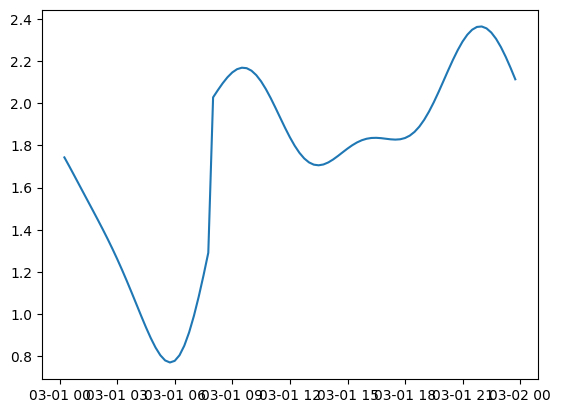

In [55]:
plt.plot(merged_df['utc'], merged_df['3d_diff'])

In [56]:
# Filtering the merged dataframe for entries from March 1st to March 2nd
# filtered_df = merged_df[(merged_df['utc'] >= '2020-03-01') & (merged_df['utc'] < '2020-03-02')]

# Selecting only the relevant columns: UTC, x_TLE, y_TLE, and z_TLE
export_df = merged_df[['utc', 'x_TLE', 'y_TLE', 'z_TLE']]

#add a new column called gpst which is utc+18 seconds
export_df['gpst'] = export_df['utc'] + pd.Timedelta(seconds=18)

def round_up_time(dt):
    # Rounds up to the nearest second
    if dt.microsecond > 0:
        dt += pd.Timedelta(seconds=1) - pd.Timedelta(microseconds=dt.microsecond)
    return dt

export_df['utc'] = export_df['utc'].apply(round_up_time)

# Now, continue with the exporting process
export_file_path = 'navstar_46_TLE_Mar1_Mar2.csv'
export_df.to_csv(export_file_path, index=False)

print(f"Data exported to {export_file_path}")


Data exported to navstar_46_TLE_Mar1_Mar2.csv


/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_15793/1973722340.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['gpst'] = export_df['utc'] + pd.Timedelta(seconds=18)
/var/folders/nh/9y501_nj2x56h2t3ch9_05f40000gn/T/ipykernel_15793/1973722340.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export_df['utc'] = export_df['utc'].apply(round_up_time)


In [114]:
#plot3D diff from march 1st to march 2nd
#first find the index closest to march 1st and march 2nd

# Calculating the 3D difference
export_df['3d_diff'] = np.sqrt((export_df['x'] - export_df['x_TLE'])**2 + (export_df['y'] - export_df['y_TLE'])**2 + (export_df['z'] - export_df['z_TLE'])**2)


march_1st = pd.to_datetime('2020-03-01 00:00:00')
march_2nd = pd.to_datetime('2020-03-02 00:00:00')

march_1st_idx = (np.abs(export_df['utc'] - march_1st)).idxmin()
march_2nd_idx = (np.abs(export_df['utc'] - march_2nd)).idxmin()

#plot the 3D difference
plt.plot(export_df['utc'][march_1st_idx:march_2nd_idx], export_df['3d_diff'][march_1st_idx:march_2nd_idx])
plt.xlabel('Time')
plt.ylabel('3D Difference (km)')
plt.title('3D Difference between SP3 and TLE: PRN11 (SVN46)')
#rotate the x-axis labels
plt.xticks(rotation=45)
plt.show()





KeyError: '3d_diff'

In [354]:
import numpy as np

def cartesian_to_keplerian(r, v, mu=398600.4418):
    """
    Convert Cartesian coordinates to Keplerian elements.

    Parameters:
    r (array): Position vector [x, y, z] in kilometers.
    v (array): Velocity vector [vx, vy, vz] in kilometers per second.
    mu (float): Standard gravitational parameter in km^3/s^2. Defaults to Earth's mu.

    Returns:
    tuple: (a, e, i, RAAN, argument_of_perigee, true_anomaly) where
        a (float): Semi-major axis in kilometers.
        e (float): Eccentricity.
        i (float): Inclination in radians.
        RAAN (float): Right ascension of the ascending node in radians.
        argument_of_perigee (float): Argument of perigee in radians.
        true_anomaly (float): True anomaly in radians.
    """

    # Calculate specific angular momentum
    h = np.cross(r, v)
    n = np.cross([0, 0, 1], h)

    # Calculate eccentricity vector
    e_vec = (np.cross(v, h) / mu) - (r / np.linalg.norm(r))
    e = np.linalg.norm(e_vec)

    # Calculate semi-major axis
    energy = np.linalg.norm(v)**2 / 2 - mu / np.linalg.norm(r)
    a = -mu / (2 * energy)

    # Calculate inclination
    i = np.rad2deg(np.arccos(h[2] / np.linalg.norm(h)))

    # Calculate right ascension of the ascending node (RAAN)
    RAAN = np.arctan2(n[1], n[0])

    # Correct RAAN for quadrant
    if RAAN < 0:
        RAAN += 2 * np.pi

    # Calculate argument of perigee
    argument_of_perigee = np.arccos(np.dot(n, e_vec) / (np.linalg.norm(n) * e))
    if e_vec[2] < 0:
        argument_of_perigee = 2 * np.pi - argument_of_perigee

    # Calculate true anomaly
    true_anomaly = np.arccos(np.dot(e_vec, r) / (e * np.linalg.norm(r)))
    if np.dot(r, v) < 0:
        true_anomaly = 2 * np.pi - true_anomaly

    return a, e, i, RAAN, argument_of_perigee, true_anomaly


In [41]:
# Add Keplerian element columns to the DataFrame
merged_ephemeris['a_TLE'] = np.nan
merged_ephemeris['e_TLE'] = np.nan
merged_ephemeris['i_TLE'] = np.nan
merged_ephemeris['RAAN_TLE'] = np.nan
merged_ephemeris['argument_of_perigee_TLE'] = np.nan
merged_ephemeris['true_anomaly_TLE'] = np.nan

# Iterate over each row to compute Keplerian elements from TLE position and velocity
for index, row in merged_ephemeris.iterrows():
    r_TLE = np.array([row['x_TLE'], row['y_TLE'], row['z_TLE']])
    v_TLE = np.array([row['xv_TLE'], row['yv_TLE'], row['zv_TLE']])
    a, e, i, RAAN, argument_of_perigee, true_anomaly = cartesian_to_keplerian(r_TLE, v_TLE)

    # Assign the calculated values to the DataFrame
    merged_ephemeris.at[index, 'a_TLE'] = a
    merged_ephemeris.at[index, 'e_TLE'] = e
    merged_ephemeris.at[index, 'i_TLE'] = i
    merged_ephemeris.at[index, 'RAAN_TLE'] = RAAN
    merged_ephemeris.at[index, 'argument_of_perigee_TLE'] = argument_of_perigee
    merged_ephemeris.at[index, 'true_anomaly_TLE'] = true_anomaly


NameError: name 'merged_ephemeris' is not defined

In [42]:


plt.figure(figsize=(10, 6))
plt.plot(merged_ephemeris['UTC'], np.rad2deg(merged_ephemeris['true_anomaly_TLE']), label='Inclination (TLE)')
plt.xlabel('UTC')
plt.ylabel('Inclination (degrees)')
plt.title('Inclination over Time (TLE Data)')
plt.legend()
plt.grid(True)

# Set y-axis to plain format to avoid scientific notation
plt.gca().ticklabel_format(style='plain', useOffset=False, axis='y')

plt.show()

NameError: name 'merged_ephemeris' is not defined

<Figure size 1000x600 with 0 Axes>